# Curtailment From Eirgrid Data 

In [28]:
#Import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pyomo.environ import *
from pyomo.util.infeasible import log_infeasible_constraints
import logging
pd.options.mode.chained_assignment = None
width = 426.79135

In [29]:
df = pd.read_excel('data/Eirgrid_data_20_21.xlsx', index_col=0) #bring in the raw data, this is in MW
market_prices = pd.read_csv('data/market_price.csv')

C:\Users\shane\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,1,8,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [30]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

## Energy data

In [31]:
#Decided to use an all Island approach as they are intrinsincally linked

all_ireland = pd.DataFrame()

#Create new columns
all_ireland['Wind Availability'] = df['IE Wind Availability']+df['NI Wind Availability']
all_ireland['Wind Generation'] = df['IE Wind Generation']+df['NI Wind Generation']
all_ireland['Demand'] = df['IE Demand']+ df['NI Demand']
all_ireland['SNSP'] = df['SNSP']

#Not entirely sure yet if this is how to get wind curtailment, shouldn't have to do the negative thing
all_ireland['Curtailment'] = all_ireland['Wind Availability'] - all_ireland['Wind Generation'] 

#set negative values to 0
all_ireland[all_ireland < 0] = 0

#remake to hourly and choose 2019
all_ireland = all_ireland.resample('H').mean() #bring it from quarter hourly data to hourly, now in MWh
all_ireland = all_ireland[all_ireland.index.year.isin([2020])]
all_ireland = all_ireland.fillna(method='ffill') #in case there's missing data fill with next value in line


In [32]:
all_ireland['SNSP'].max() #This makes sense with whats in the report, was increased to 65%

0.66245

In [33]:
all_ireland['Wind Generation'].max()

4207.56625

In [34]:
per_dispactch_down = (all_ireland['Curtailment'].sum()/all_ireland['Wind Availability'].sum())*100
total_gen = round(all_ireland['Wind Generation'].sum()/1000,2)
total_dispatch_down = round(all_ireland['Curtailment'].sum()/1000,2)

print(total_gen, 11076) #so the over
print(total_dispatch_down, 707)
print('% dispatch down = {}'.format(round(per_dispactch_down,2)))


13698.8 11076
2089.07 707
% dispatch down = 13.23


In [35]:
print('Only {}% of dispatch down in this data makes it to the final report'.format(round(707/(all_ireland['Curtailment'].sum()/1000)*100,2)))

Only 33.84% of dispatch down in this data makes it to the final report


In [36]:
#Making these figures agree with what was in the report
scaling_factor = 12.1/per_dispactch_down
all_ireland['Curtailment'] = all_ireland['Curtailment']*scaling_factor

In [37]:
all_ireland['Curtailment'].sum() #closer now

1910155.488516

## Price data

In [38]:
#Start arranging the price data here, have only used the Day ahead market really
prices = market_prices[market_prices['auction'] == 'DAM']
prices.index = pd.to_datetime(prices['timestamp'])

In [39]:
prices = prices[prices.index.year.isin([2020])]
prices.index = all_ireland.index[0:8783]
all_ireland['Day Ahead Price'] = prices['price_eur']
all_ireland = all_ireland.dropna()

# Actual model

In [40]:
class storage:
    def __init__(self,capacity_cost,power_cost,efficiency,hours_of_storage,capacity,asset_life,power,
                self_discharge_rate=None):
        self.capacity_cost = capacity_cost
        self.power_cost = power_cost
        self.efficiency = efficiency
        self.hours_of_storage = hours_of_storage
        self.capacity = capacity
        self.power = power
        self.asset_life = asset_life
        self.self_discharge_rate = self_discharge_rate

In [41]:
#Define the different technologys
iron_air = storage(capacity_cost=10.75*1000,power_cost=1075,efficiency=.45,hours_of_storage=100,capacity=100,power=1000,
                   asset_life=10,self_discharge_rate=None)

li_ion = storage(capacity_cost=324*1000,power_cost=1296,efficiency=.9,hours_of_storage=4,capacity=100,power=1000,
                   asset_life=10,self_discharge_rate=None)

storage_ops = [iron_air, li_ion]
names = ['Iron-Air Battery', 'Lithium-Ion Battery']

In [103]:
class simulation:
    def __init__(self, data, storage):
        #This should bring in the data
        self.data = data
        self.storage = storage
    
    def run(self):
        self.data = self.data.dropna()
        self.data.index = range(1,len(self.data)+1)
        #Create the model
        model = ConcreteModel()

        #Everything will be done in timesteps
        model.t = RangeSet(len(self.data))

        #Define a few parameters that will model on the constraints
        model.e_available = Param(model.t, initialize=self.data['Curtailment'])
        model.efficiency = Param(initialize=self.storage.efficiency)
        model.price = Param(model.t, initialize=self.data['Day Ahead Price'])
        model.max_out = Param(model.t, initialize=self.data['Demand'] - self.data['Wind Generation'])

        #The variables of the problem
        model.charge = Var(model.t, domain=NonNegativeReals)
        model.e_in = Var(model.t, domain=NonNegativeReals) #this is the amount of energy not curtailed
        model.e_out = Var(model.t, domain=NonNegativeReals)
        model.capacity = Var(domain=NonNegativeReals) 
        model.power = Var(domain=NonNegativeReals)

        #The battery charge is equal to previous time step plus charge minus discharge, tick
        def state_of_charge(model,t):
            if t == 1:
                return model.charge[t] == 0
            else:
                return model.charge[t] == model.charge[t-1] + model.e_in[t-1]*model.efficiency - model.e_out[t-1]
        model.soc = Constraint(model.t, rule=state_of_charge)
        
        #Charge of the battery can't exceed the capacity, tick
        def max_charge(model, t):
            return model.charge[t] <= model.capacity
        model.max_charge = Constraint(model.t, rule=max_charge)

        #Power in can't exceed the rate limit combined with effiency, tick
        def power_in(model,t): 
            return model.e_in[t] <= model.power
        model.pow_in = Constraint(model.t, rule=power_in)
        
        #Power out can't exceed the rate limit combined with effiency, tick
        def power_out(model,t):
            return model.e_out[t] <= model.power
        model.pow_out = Constraint(model.t, rule=power_out)
        
        #Charging of the battery must be less than or equal to the amount of energy available
        def charging_con(model,t):
            return model.e_in[t] == model.e_available[t]
        model.con1 = Constraint(model.t, rule=charging_con)
        
        #Discharging of the battery must be less than or equal to the amount of energy available
        def discharging_con(model,t): 
            return model.e_out[t] <= model.charge[t]
        model.con2 = Constraint(model.t, rule=discharging_con)
        
        #The hours of storage chosen must be less than or equal to the technology allows
        def storage_hours(model):
            return model.power == model.capacity/self.storage.hours_of_storage
        model.con3 = Constraint(rule=storage_hours)
        
        #Wanted to reduce the massive discharges, can only output demand - wind at once
        def max_output(model,t): 
            return model.e_out[t] <= model.max_out[t]
        model.con4 = Constraint(model.t, rule=max_output)
        
        #objective function, minimize the cost of the system. Want to include curtailment in some way
        profit = sum(model.price[t]*model.e_out[t] for t in model.t) - self.storage.capacity_cost*model.capacity
        model.obj = Objective(expr=profit, sense=maximize)

        # Solve the model
        solver = SolverFactory('glpk')
        results = solver.solve(model, tee=True)
        
        return model


In [104]:
results = []

#for each storage option run the optimization
for x in storage_ops:
    sim = simulation(all_ireland, x)
    model = sim.run()
    results.append(model)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\shane\AppData\Local\Temp\tmp29v133cd.glpk.raw --wglp C:\Users\shane\AppData\Local\Temp\tmp_k1y1wfv.glpk.glp
 --cpxlp C:\Users\shane\AppData\Local\Temp\tmp0fg4_u6h.pyomo.lp
Reading problem data from 'C:\Users\shane\AppData\Local\Temp\tmp0fg4_u6h.pyomo.lp'...
61483 rows, 26352 columns, 122962 non-zeros
342477 lines were read
Writing problem data to 'C:\Users\shane\AppData\Local\Temp\tmp_k1y1wfv.glpk.glp'...
272157 lines were written
GLPK Simplex Optimizer 5.0
61483 rows, 26352 columns, 122962 non-zeros
Preprocessing...
30067 rows, 17564 columns, 68914 non-zeros
Scaling...
 A: min|aij| =  1.000e-02  max|aij| =  1.000e+00  ratio =  1.000e+02
GM: min|aij| =  5.425e-01  max|aij| =  1.843e+00  ratio =  3.398e+00
EQ: min|aij| =  2.943e-01  max|aij| =  1.000e+00  ratio =  3.398e+00
Constructing initial basis...
Size of triangular part is 30067
      0: obj =   1.503707019e+07 inf =   4.813e+05 (12524)
 

In [105]:
len(all_ireland.index)

8783

In [106]:
#try and bring these for each storage option
opt_results = {}
j = 0

for opt in results:
    charge = []
    e_in = []
    e_out = []
    
    #grab all the values from the model
    for i in range(1,len(all_ireland)):
        charge.append(value(opt.charge[i]))
        e_in.append(value(opt.e_in[i]))
        e_out.append(value(opt.e_out[i]))
    
    #just makes things easier to manipulate
    charge = pd.Series(charge)
    e_in  = pd.Series(e_in)
    e_out  = pd.Series(e_out)
    
    opt_results[j] = [charge,e_in,e_out]
    j = j+1
    
    

In [107]:
opt_results[0][1].sum()

1909379.7081110394

In [108]:
e_in.sum()

1909379.7081110394

In [109]:
all_ireland['Curtailment'].sum()

1909785.737626011

In [110]:
len(results[0].t)

8783

In [111]:
names[0]

'Iron-Air Battery'

In [112]:
j = 0

#Using an Iterator again to grab the names
for opt in results:
    name = names[j]
    print('Results for the {}:'.format(name))
    print("Capacity is {:.0f} MWh".format(opt.capacity()))
    print("Power is {:.0f} MW".format(opt.power()))
    print("Cost is this {:.0f}".format(opt.obj()))
    j = j + 1
    

Results for the Iron-Air Battery:
Capacity is 284251 MWh
Power is 2843 MW
Cost is this -2961397075
Results for the Lithium-Ion Battery:
Capacity is 20203 MWh
Power is 5051 MW
Cost is this -6418787622


In [113]:
622769*10000.75

6228157076.75

In [117]:
opt_results[0][1].index

RangeIndex(start=0, stop=8782, step=1)

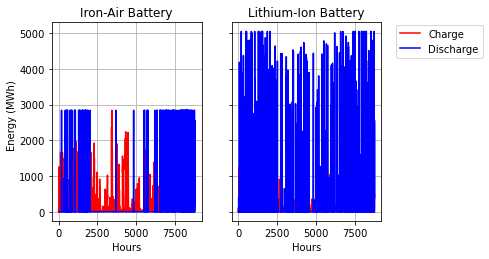

In [127]:
fig,ax = plt.subplots(1, 2, figsize = set_size(width), sharey=True)

#apparently have to draw the canvas before it can get ticks?
fig.canvas.draw()

for i in range(len(storage_ops)):
    ax[i].set_xlabel("Hours", fontsize = 10)
    ax[i].grid(True)
    ax[i].set_title(names[i], fontsize=12)
    ax[i].plot(opt_results[i][1][0:len(opt_results[i][1])], label='Charge', color='red')
    ax[i].plot(opt_results[i][2][0:len(opt_results[i][1])], label='Discharge', color='blue')
    #plt.draw()
    #labels = ax[i].get_xticklabels()
    #ax[i].set_xticklabels(labels, rotation=40, fontsize=8)
    #handles, labels = ax[i].get_legend_handles_labels()
    #ax[i].tick_params(axis='y', labelsize=8)
    #ax[i].xaxis.set_major_locator(plt.MaxNLocator(5))
#
fig.legend(handles, labels, fontsize=10, bbox_to_anchor=(0.65, 0, 0.5, 0.89))
fig.text(0.02, 0.4, "Energy (MWh)", fontsize=10, rotation='vertical')
# Save and remove excess whitespace
fig.savefig('images/iron_li_peform.png', format='png', dpi=500, bbox_inches='tight')
plt.show()


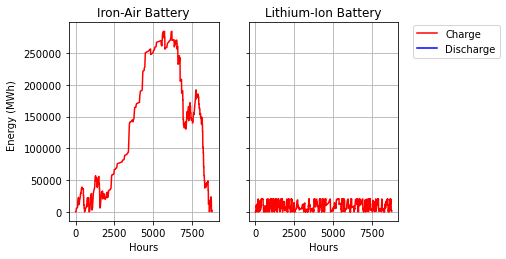

In [135]:
fig,ax = plt.subplots(1, 2, figsize = set_size(width), sharey=True)

#apparently have to draw the canvas before it can get ticks?
fig.canvas.draw()

for i in range(len(storage_ops)):
    ax[i].set_xlabel("Hours", fontsize = 10)
    ax[i].grid(True)
    ax[i].set_title(names[i], fontsize=12)
    ax[i].plot(opt_results[i][0], label='State of Charge', color='red')
    #plt.draw()
    #labels = ax[i].get_xticklabels()
    #ax[i].set_xticklabels(labels, rotation=40, fontsize=8)
    #handles, labels = ax[i].get_legend_handles_labels()
    #ax[i].tick_params(axis='y', labelsize=8)
    #ax[i].xaxis.set_major_locator(plt.MaxNLocator(5))
    #
fig.legend(handles, labels, fontsize=10, bbox_to_anchor=(0.65, 0, 0.5, 0.89))
fig.text(-.02, 0.4, "Energy (MWh)", fontsize=10, rotation='vertical')
fig.savefig('images/iron_li_soc.png', format='png', dpi=500,  bbox_inches='tight')
plt.show()